# **IMPORTATION DES PACKAGES**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn as sk

from fancyimpute import KNN

from scipy.stats import norm

Using TensorFlow backend.


In [2]:
# Loading train.csv into a dataframe
train_df = pd.read_csv('train.csv')

# view of the first 10 rows
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Ce dataset contient 1460 observations et 81 colonnes.

# **NETTOYAGE DES DONNEES**

In [4]:
train_df.duplicated().sum()

0

Notre dataset ne contient aucune duplication. Nous allons egalement supprimer la colonne Id vu que ce n'est juste qu'une incrémentation afin de classer les observations.

In [5]:
train_df.drop('Id', axis=1, inplace=True)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Voyons s'il n'ya pas de valeurs manquantes.

Text(0.5, 1.0, 'Visualizing null values per column')

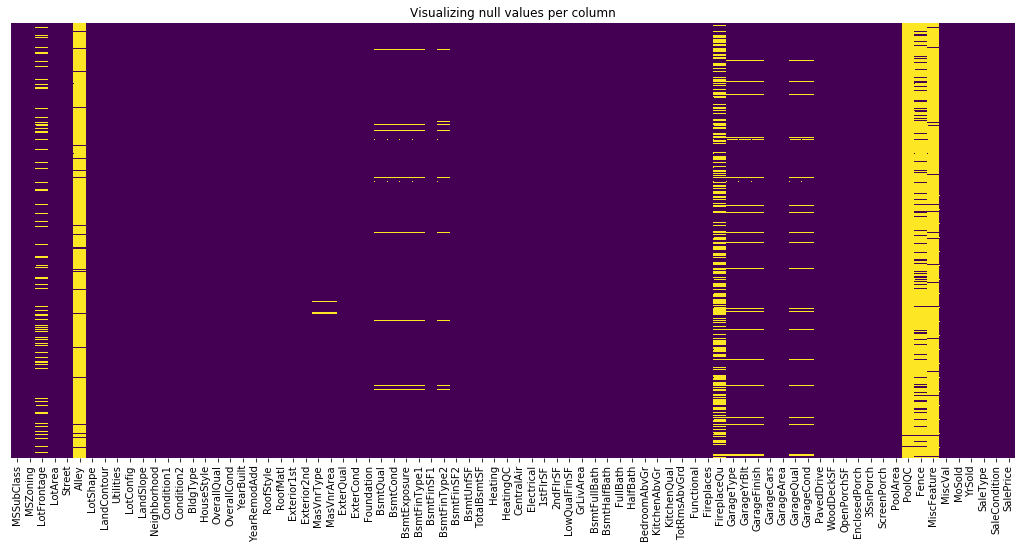

In [6]:
plt.figure(figsize=(18,8))
sns.heatmap(train_df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Visualizing null values per column')

Ce graphe est un peu difficile a interpreter. Essayons de simplifier en creant un nouveau dataframe contenant que les colonnes avec les valeurs manquantes.

In [7]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_values_count']
missing_df = missing_df.loc[missing_df['missing_values_count'] > 0]
missing_df['percentage'] = 100 * (missing_df['missing_values_count']/len(train_df))
missing_df = missing_df.sort_values(by='missing_values_count', ascending=False)
missing_df

,column_name,missing_values_count,percentage
71,PoolQC,1453,99.520548
73,MiscFeature,1406,96.301370
5,Alley,1369,93.767123
72,Fence,1179,80.753425
56,FireplaceQu,690,47.260274
2,LotFrontage,259,17.739726
57,GarageType,81,5.547945
58,GarageYrBlt,81,5.547945
59,GarageFinish,81,5.547945
62,GarageQual,81,5.547945


Text(0, 0.5, 'Columns with missing values')

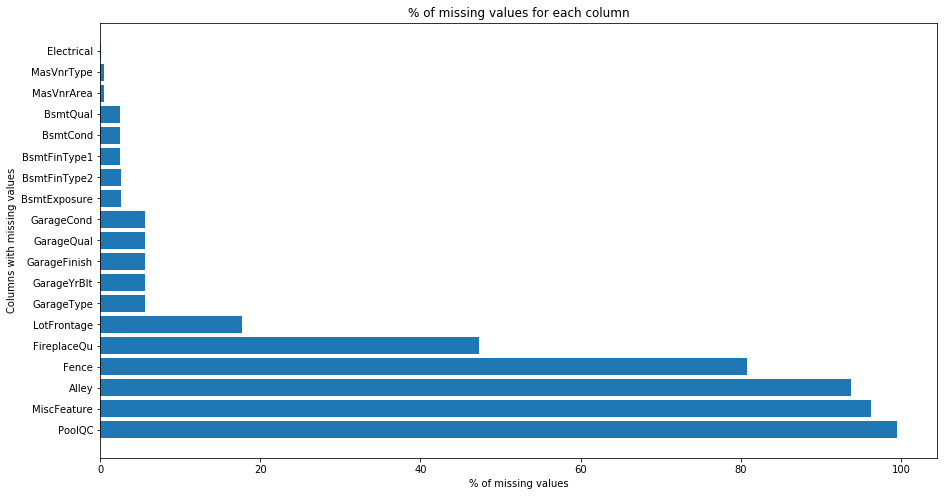

In [8]:
plt.figure(figsize=(15,8))
plt.barh(missing_df.column_name, missing_df.percentage)
plt.title('% of missing values for each column')
plt.xlabel('% of missing values')
plt.ylabel('Columns with missing values')

Nous savons deja a partir de la description que les valeurs manquantes pour:
- BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure indique qu'il n'ya pas de basement.
- GarageType, GarageFinish, GarageQual and GarageCond indique qu'il n'ya pas de garage.
- GarageYrBlt: pourrait etre une erreur d'enregistrement. Soit y'a pas de garage ou la valeur n'a pas bien ete enregistrée..
- FireplaceQu indique qu'il n'ya pas de Fireplace.
- Fence indique qu'il n'ya pas de fence.
- Alley indique qu'il n'ya pas d'alley.
- MiscFeature indique qu'il n'ya pas de miscellaneous features.
- PoolQC indique qu'il n'ya pas de piscine.

Nous utiliserons la stratégie suivante pour les valeurs manquantes:
- Si le pourcentage est inferieur a 5 et que les valeurs sont vraiment manquantes, Nous allons supprimer les observations avec des valeurs manquantes. Autrement, nous allons juste corriger les donnees.
- Si le pourcentage est superieur a 60 **et** que la variable n'est pas significative alors ce dernier sera omis, sinon nous essayerons d'imputer les valeurs nulles.

D'abord nous allons corriger les "fausses" donnees manquantes avec "None".

**BsmtQual - BsmtCond - BsmtFinType1 - BsmtFinType2 - BsmtExposure - FireplaceQu - Fence - Alley - MiscFeature - PoolQC**

In [9]:
train_df[['BsmtQual', 'BsmtCond', 'BsmtFinType1',
          'BsmtFinType2', 'BsmtExposure',
         'FireplaceQu', 'Fence', 'Alley',
          'MiscFeature', 'PoolQC']] = train_df[['BsmtQual', 'BsmtCond', 
                                                'BsmtFinType1', 'BsmtFinType2', 
                                                'BsmtExposure',
                                               'FireplaceQu', 'Fence', 'Alley',
                                                'MiscFeature', 'PoolQC']].fillna('None')

**GarageType - GarageFinish - GarageQual - GarageCond**
Vu que aucune information n'a ete fournie concernant les valeurs manquantes pour GarageYrBlt(l'annee de construction du garage), nous allons verifier si les index pour lesquels GarageYrBlt est null correspond aux autres valeurs manquantes pour les autres colonnes ayant les autres caracteristiques liés au garage, puisque s'il n'ya pas de garage toutes les caracteristiques liées devraient etre nulles.

In [10]:
np.unique(train_df.loc[train_df.GarageFinish.isnull() 
            | train_df.GarageType.isnull() | train_df.GarageQual.isnull() | train_df.GarageCond.isnull()].index == train_df.loc[train_df.GarageYrBlt.isnull()].index)

array([ True])

Les index coincident alors on peut remplacer les champs vides par "No Garage".

In [11]:
train_df[['GarageType', 'GarageFinish',
          'GarageQual', 'GarageCond', 'GarageYrBlt']] = train_df[['GarageType', 'GarageFinish',
                                                                  'GarageQual', 'GarageCond',
                                                                  'GarageYrBlt']].fillna('None')

Mettons a jour notre dataframe de valeurs manquantes.

In [12]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_values_count']
missing_df = missing_df.loc[missing_df['missing_values_count'] > 0]
missing_df['percentage'] = 100 * (missing_df['missing_values_count']/len(train_df))
missing_df = missing_df.sort_values(by='missing_values_count', ascending=False)
missing_df

,column_name,missing_values_count,percentage
2,LotFrontage,259,17.739726
24,MasVnrType,8,0.547945
25,MasVnrArea,8,0.547945
41,Electrical,1,0.068493


En suivant la stratégie mentionnée au depart nous allons maintenant supprimer les observations ayant des valeurs manquantes pour MasVnrType, MasVnrArea et Electrical.

In [13]:
train_df.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical'], inplace=True)

Maintenant puisque le pourcentage de valeurs manquantes pour LotFrontage est superieur a 5% mais inferieur a 60%, nous allons effectuer une imputation en utilisant le principe KNN de la librairie fancyimpute.

In [14]:
# creation dataframe avec seulement les valeurs numeriques
numeric_train_df = train_df.select_dtypes(include=['number'])
numeric_train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [15]:
# on utilisera k = racine carré de la taille du dataset
k = int(np.sqrt(len(numeric_train_df)))

# nouveau dataframe avec les valeurs imputées
numeric_train_df_completed = pd.DataFrame(data=KNN(k).fit_transform(numeric_train_df), columns=numeric_train_df.columns, index=numeric_train_df.index)

Imputing row 1/1451 with 0 missing, elapsed time: 0.856
Imputing row 101/1451 with 1 missing, elapsed time: 0.862
Imputing row 201/1451 with 0 missing, elapsed time: 0.866
Imputing row 301/1451 with 0 missing, elapsed time: 0.869
Imputing row 401/1451 with 0 missing, elapsed time: 0.872
Imputing row 501/1451 with 0 missing, elapsed time: 0.874
Imputing row 601/1451 with 0 missing, elapsed time: 0.877
Imputing row 701/1451 with 0 missing, elapsed time: 0.879
Imputing row 801/1451 with 0 missing, elapsed time: 0.881
Imputing row 901/1451 with 0 missing, elapsed time: 0.884
Imputing row 1001/1451 with 1 missing, elapsed time: 0.885
Imputing row 1101/1451 with 0 missing, elapsed time: 0.887
Imputing row 1201/1451 with 1 missing, elapsed time: 0.890
Imputing row 1301/1451 with 0 missing, elapsed time: 0.892
Imputing row 1401/1451 with 0 missing, elapsed time: 0.894


In [16]:
train_df['LotFrontage'] = numeric_train_df_completed['LotFrontage']

In [17]:
# s'assurer qu'il ne reste plus de valeurs manquantes.
train_df.isnull().values.any()

False

# **ANALYSE EXPLORATOIRE**

Le but de ce projet c'est d'avoir un modele capable de predire avec la plus grande precision possible le prix d'une maison en se basant sur certaines caracteristiques.
Nous allons en conséquent essayer de determiner les caracteristiques qui ont une influence sur le prix.

Commencons d'abord par une analyse univariée de SalePrice vu que c'est notre variable cible.

In [18]:
train_df.SalePrice.describe()

count      1451.000000
mean     180624.101999
std       79312.128273
min       34900.000000
25%      129900.000000
50%      162500.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Les valeurs revolvent autour de 180624 avec une deviation standard de 79312.

On remarque un maximum de 755000, ce qui est nettement plus grand que le 75eme percentile. Donc il y'a bien des valeurs aberrantes dans la distribution.

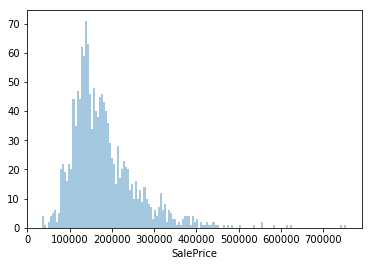

In [19]:
sns.distplot(train_df['SalePrice'], bins=150, kde=False)

Nous remarquons que cette distribution est asymmetriquement normal avec une queue qui tend vers la droite.
Voyons ce que donne le CDF(cumulative distribution function).

In [20]:
def generateCDF(sample):
    x = np.sort(sample)
    y = np.linspace(0, 1, len(sample))
    return x,y

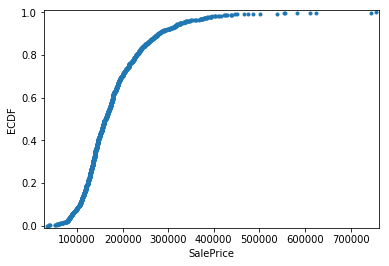

In [21]:
x, y = generateCDF(train_df['SalePrice'])

plt.plot(x, y, marker='.', linestyle='')
plt.xlabel('SalePrice')
plt.ylabel('ECDF')
plt.margins(0.01)

On pourrait assumer qu'une distribution normale décrit cette variable. Pour verifier nous allons generer une distribution normale ayant la meme moyenne et la meme deviation standard.

In [22]:
mean = train_df['SalePrice'].mean()
std = train_df['SalePrice'].std()
size = len(train_df)

sample = list(norm(loc=mean, scale=std).rvs(size=size))
xs, ys = generateCDF(sample)

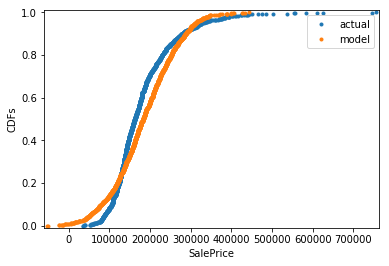

In [23]:
plt.plot(x, y, marker='.', linestyle='', label='actual')
plt.plot(xs, ys, marker='.', linestyle='', label='model')
plt.xlabel('SalePrice')
plt.ylabel('CDFs')
plt.legend()
plt.margins(0.01)

La distribution normale ne decrit pas parfaitement cette variable. La marge d'erreur est assez importante.
Peut etre qu'une distribution log-normale fera l'affaire.

In [24]:
log_prices = np.log(train_df['SalePrice'])
x, y = generateCDF(log_prices)

mean = log_prices.mean()
std = log_prices.std()
size = len(train_df)

sample = list(norm(loc=mean, scale=std).rvs(size=size))
xs, ys = generateCDF(sample)

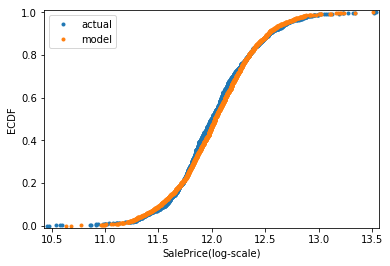

In [25]:
plt.plot(x, y, marker='.', linestyle='', label='actual')
plt.plot(xs, ys, marker='.', linestyle='', label='model')
plt.xlabel('SalePrice(log-scale)')
plt.ylabel('ECDF')

plt.margins(0.01)
plt.legend()

La distribution log-normale decrit assez bien la variable SalePrice.
Cependant comme noté plutot, il y'a de possibles valeurs aberrantes.

Text(0.5, 1.0, 'Visualizing outliers in SalePrice')

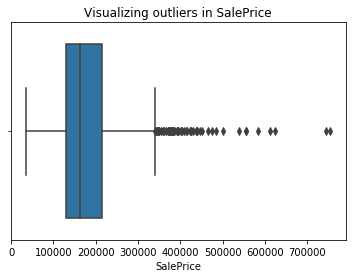

In [26]:
sns.boxplot(train_df['SalePrice'])
plt.title('Visualizing outliers in SalePrice')

En effet y'a beaucoup de valeurs aberrantes. Toutefois, elle ne sont pas forcement mauvaises. Donc nous allons uniquement supprimer les valeurs aberrantes **extreme**, c'est a dire qui sont 3 fois en dessous du premier quartile ou au dessus du troisieme quartile.

In [27]:
first_quartile = train_df['SalePrice'].describe()['25%']
third_quartile = train_df['SalePrice'].describe()['75%']
iqr = third_quartile - first_quartile

train_df[(train_df['SalePrice'] < (first_quartile - 3 * iqr)) 
                        | (train_df['SalePrice'] > (third_quartile + 3 * iqr))]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
178,20,RL,63.000000,17423,Pave,None,IR1,Lvl,AllPub,CulDSac,...,0,None,None,None,0,7,2009,New,Partial,501837
185,75,RM,90.000000,22950,Pave,None,IR2,Lvl,AllPub,Inside,...,0,None,GdPrv,None,0,6,2006,WD,Normal,475000
440,20,RL,105.000000,15431,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2009,WD,Normal,555000
691,60,RL,104.000000,21535,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,1,2007,WD,Normal,755000
769,60,RL,47.000000,53504,Pave,None,IR2,HLS,AllPub,CulDSac,...,0,None,None,None,0,6,2010,WD,Normal,538000
798,60,RL,104.000000,13518,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,7,2009,New,Partial,485000
803,60,RL,107.000000,13891,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,1,2009,New,Partial,582933
898,20,RL,100.000000,12919,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,3,2010,New,Partial,611657
1046,60,RL,85.000000,16056,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,7,2006,New,Partial,556581
1169,60,RL,118.000000,35760,Pave,None,IR1,Lvl,AllPub,CulDSac,...,0,None,None,None,0,7,2006,WD,Normal,625000


Ces observations contiennent des valeurs aberrantes extreme. Nous allons donc les supprimer pour eviter de fausser notre futur modele.

In [28]:
train_df = train_df[(train_df['SalePrice'] > (first_quartile - 3 * iqr)) 
                        & (train_df['SalePrice'] < (third_quartile + 3 * iqr))]

Pour la suite nous allons travailler avec les valeurs numeriques.

In [29]:
numeric_features=train_df.select_dtypes(include=[np.number])
numeric_features.dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [30]:
#Affichage de la corrélation entre les colonnes 
corr=numeric_features.corr()
print(corr['SalePrice'].sort_values(ascending=False)[:5],'\n')
print(corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.799087
GrLivArea      0.680625
GarageCars     0.653281
GarageArea     0.631755
Name: SalePrice, dtype: float64 

LowQualFinSF    -0.060098
OverallCond     -0.077853
MSSubClass      -0.084841
EnclosedPorch   -0.128849
KitchenAbvGr    -0.145533
Name: SalePrice, dtype: float64


Etudions OverallQual vu que c'est l'une des variables avec une tres forte correlation avec SalePrice.

In [31]:
#Affichage des données OverallQual avec des valeurs uniques
x=train_df.OverallQual.unique()
x

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [33]:
quality_pivot=train_df.pivot_table(index='OverallQual',values='SalePrice',aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,159750
7,201000
8,269750
9,334084


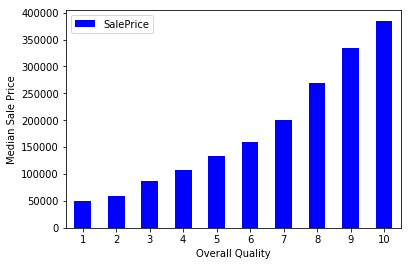

In [34]:
quality_pivot.plot(kind='bar',color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

On constate que plus la qualité augmente plus le prix augmente, ce qui est logique d'ailleurs.
Voyons maintenant la relation entre GrLivArea et SalePrice.

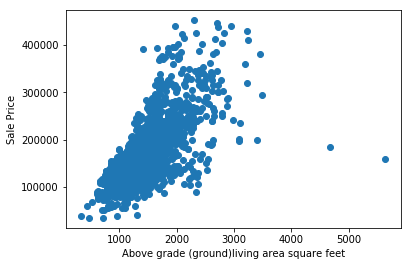

In [38]:
plt.scatter(x=train_df['GrLivArea'],y=train_df['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground)living area square feet')
plt.show()

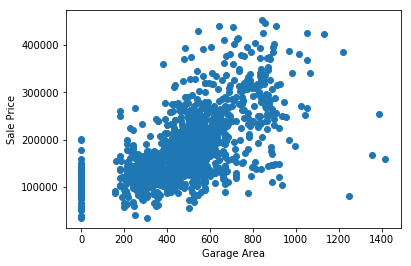

In [39]:
#Diagramme de dispersion,relation entre garage area et saleprice
plt.scatter(x=train_df['GarageArea'],y=train_df['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

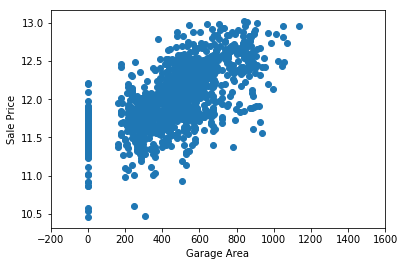

In [40]:
train=train_df[train_df['GarageArea']<1200]
plt.scatter(x=train['GarageArea'],y=np.log(train.SalePrice))
plt.xlim(-200,1600)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

Traitons maintenant les valeurs non numeriques pour voir lesquelles on peut transformer.

In [41]:
#Les caractéristiques non numériques
categoricals=train_df.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,...,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439
unique,5,2,3,4,4,2,5,3,25,9,...,98,4,6,6,3,4,5,5,9,6
top,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,None,Unf,TA,TA,Y,None,None,None,WD,Normal
freq,1134,1433,1349,914,1291,1438,1038,1362,225,1240,...,81,604,1291,1305,1319,1433,1160,1385,1254,1187


In [42]:
#Transformation et feature engineering
#Considérons la colonne Street et vérifions s'il y'a un accès de gravier ou de route pavée
print("Original: \n")
print(train_df.Street.value_counts(), "\n")

Original: 

Pave    1433
Grvl       6
Name: Street, dtype: int64 



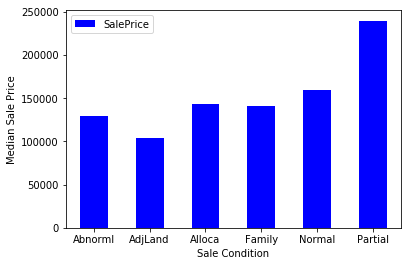

In [43]:
#Tableau croisé dynamique entre Sale Price et Sale Condition
condition_pivot = train_df.pivot_table(
index='SaleCondition',
values='SalePrice',
aggfunc=np.median
)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

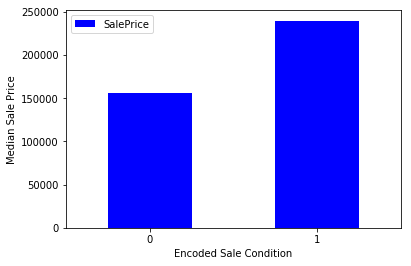

In [45]:
#Encodage de partial ;il prend 1 si saleCondition==partial et 0 sinon 
test = pd.read_csv("test.csv")
def encode(x): return 1 if x == 'Partial' else 0
train_df['enc_condition'] = train_df.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)
#Traçage du tableau croisé entre encoded Sale Condition et Sale Price
condition_pivot = train_df.pivot_table(
index='enc_condition',
values='SalePrice',
aggfunc=np.median
)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [46]:
#Remplissage des valeurs manquantes puis affecter les résultats aux données:interpolation
data = train_df.select_dtypes(include=[np.number]).interpolate()
#Vérification
x=sum(data.isnull().sum()!=0)
x

0

In [48]:
#Construire un modèle linéaire
#Exclusion de la variable SalePrice elle sera séparée des autres entités pour la modélisation 
y = np.log(train_df.SalePrice)
X = data.drop(['SalePrice'], axis=1)
#Partition des données 
#Création d'un ensemble de formation et un de maintien
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
random_state=42,
test_size=.33
)
#Commençons la modélisation
#Instanciation du modèle de régression linéaire
from sklearn import linear_model
lr = linear_model.LinearRegression()
#Adaptation du modèle
model = lr.fit(X_train, y_train)
#Evaluation de la performance et visualisation des résultats
print ("R^2: \n", model.score(X_test, y_test))

R^2: 
 0.8667086327530943


In [49]:
#Prédiction sur le jeu de données test
predictions = model.predict(X_test)
#Calcul de la  valeur rmse
from sklearn.metrics import mean_squared_error
print ('RMSE = \n', mean_squared_error(y_test, predictions))

RMSE = 
 0.018682886592813502


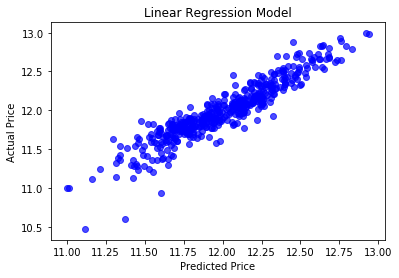

In [50]:
#Visualisation à travers un nuage de points de la relation entre les valeurs réelles et celles prédites
actual_values = y_test
plt.scatter(
predictions, actual_values,
alpha=.7,
color='b'
) #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()



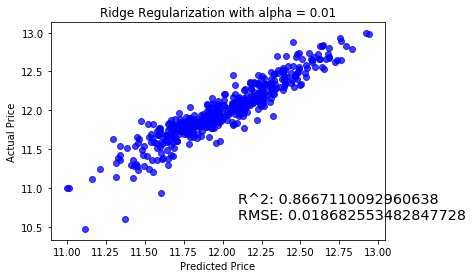

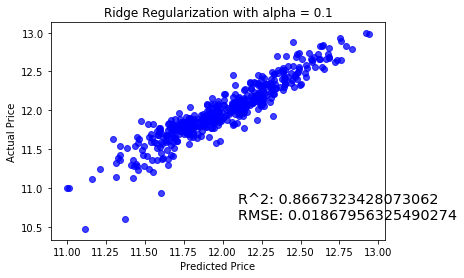

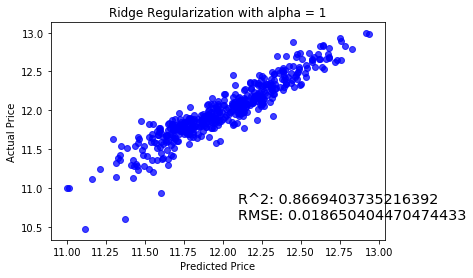

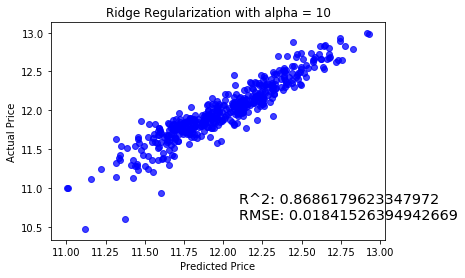

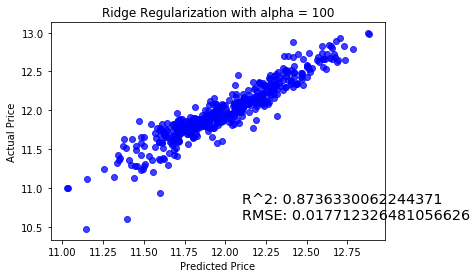

In [51]:
#Essayons d'améliorer le modèle
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2: {}\nRMSE: {}'.format(

        ridge_model.score(X_test, y_test),
        mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

Nous pouvons voir que le meilleur modele est obtenu avec un alpha ridge de 100.